<a href="https://colab.research.google.com/github/JyothiKarna/High-Performance-Computing/blob/main/HW4_Basic_CNN_implementation_SivaJyothiKarna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score

assert tf.__version__.startswith('2.') 
# Default float to be 'float32' (So far, Tensorflow only works with float8, 16, 32)
tf.keras.backend.set_floatx('float32')
# Fix random seed for tensorflow / numpy 
tf.random.set_seed(77777)
np.random.seed(77777)

# This is for making directories where to save trained model and snapshots:
if os.path.isdir('CNN Classifier Models') == False:
    os.mkdir('CNN Classifier Models')

In [ ]:
# Load CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
Name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 14s 0us/step


The number of training data: 50000 
The number of testing data: 10000


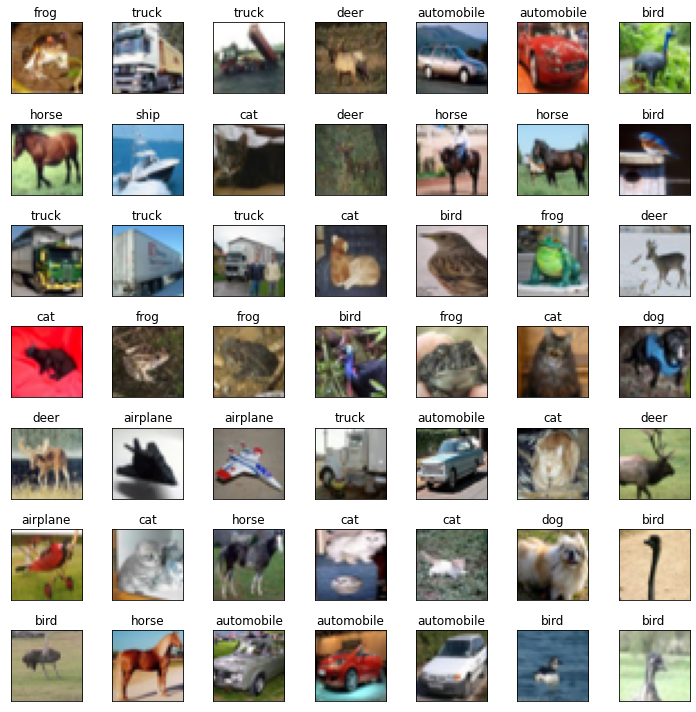

In [ ]:
# Visualize MPS realizations from the above training image:
print(f'The number of training data: {x_train.shape[0]} \nThe number of testing data: {x_test.shape[0]}')

# Visualize training images:
c, r = 7, 7
plt.figure(figsize = (10,10))
for i in range(c*r):
    plt.subplot(c,r,i+1)
    fig = plt.imshow(x_train[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(Name[y_train[i,0]])
plt.tight_layout()

Shape of training image: 32 X 32 X 3 in X, Y, and channels


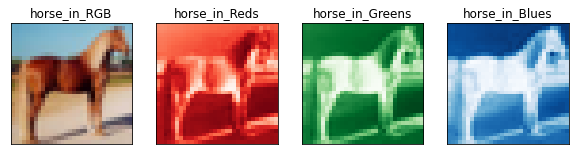

In [ ]:
# Please note that each image has thee channels for R, G, and B:
print(f'Shape of training image: {x_train.shape[1]} X {x_train.shape[2]} X {x_train.shape[3]} in X, Y, and channels')

plt.figure(figsize= (10,5))
plt.subplot(1,4,1)
fig = plt.imshow(x_train[43])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title(Name[y_train[43,0]]+'_in_RGB')
RGB_name = ['Reds', 'Greens', 'Blues'];

for i in range(3):
    plt.subplot(1,4,i+2)
    fig = plt.imshow(x_train[43,:,:,i],cmap = RGB_name[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(Name[y_train[43,0]]+'_in_'+RGB_name[i])


In [ ]:
# Preprocess training data:
from sklearn.preprocessing import OneHotEncoder
x_train_n, x_test_n = x_train / 255, x_test / 255 # to rescale image from 0 to 1
y_train_one_hot, y_test_one_hot = OneHotEncoder().fit_transform(y_train), OneHotEncoder().fit_transform(y_test)

In [ ]:
def CNN_model():
    # define neural network model sequentially
    model = tf.keras.Sequential()
    # Feature map 1: (32x32x3) --> (16x16x16)
    model.add(layers.Conv2D(16, kernel_size=(3,3), strides=2, input_shape=[32,32,3], padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    # Feature map 2: (16x16x16) --> (8x8x32)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    # Feature map 3: (8x8x32) --> (4x4x32)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    # Output layer: (4x4x64) --> 10 (i.e., each node corresponds to the probability to be each class)
    model.add(layers.Dense(10, activation = 'softmax'))   # <- Softmax is an activation function for classfier
    
    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')
    return model

In [ ]:
# Instantiate model
model = CNN_model()
model.summary()

# training the Neural Network and saving metrics every 100 epochs
checkpoint_filepath = 'CNN Classifier Models/CNN_Model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(x_train_n, y_train_one_hot.todense(), 
                    batch_size=64, epochs=20, verbose=2, 
                    validation_data=(x_test_n, y_test_one_hot.todense()),
                    callbacks=[model_checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        448       
                                                                 
 re_lu_3 (ReLU)              (None, 16, 16, 16)        0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 re_lu_4 (ReLU)              (None, 8, 8, 32)          0         
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 32)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)         

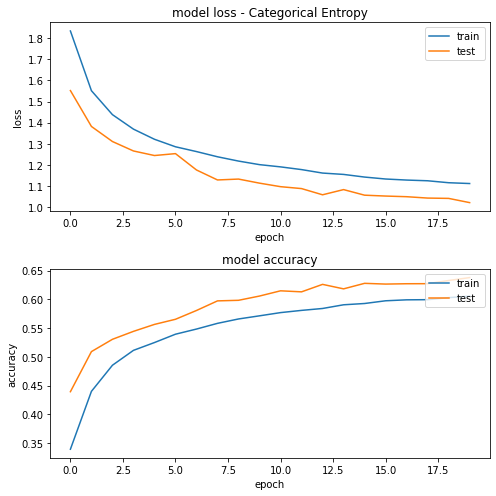

In [ ]:
plt.figure(figsize = (7,7))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss - Categorical Entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.subplot(2,1,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [ ]:
# c) Use larger CNN model (20 points)
# Add more Convolution/BatchNorm/Pooling/DropOut/Linear layers to improve the accuracy. Higher accuracy will get higher grade.

# Larger/ Deeper CNN

def CNN_model_deeper():
    # define convolutional neural network model sequentially
    model = tf.keras.Sequential()
    # Feature map 1: (32x32x3) --> (16x16x64)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, input_shape=[32,32,3], padding="same"))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Feature map 2: (16x16x64) --> (8x8x128)
    model.add(layers.Conv2D(64, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Feature map 3: (8x8x128) --> (4x4x256)
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())

    # Hidden layer 1: (4x4x256) --> 1024
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Hidden layer 2: 1024 --> 512
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))

    # Hidden layer 3: 512 --> 256
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))
    
    # Hidden layer 4: 256 --> 128
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.25))   
    
    # Output layer: 128 --> 10
    model.add(layers.Dense(10, activation = 'softmax'))   # <- Softmax is an activation function for classfier
    
    # Compile the Neural Network - define Loss and optimizer to tune the associated weights
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=optimizer)
    return model


In [ ]:
# Instantiate model
model_deep = CNN_model_deeper()
# model_deep.summary()


# training the Convolutional Neural Network and saving metrics every 100 epochs
checkpoint_filepath = 'CNN Classifier Models/CNN_Deep_Model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
history_deep = model_deep.fit(x_train_n, y_train_one_hot.todense(), 
                    batch_size=64, epochs=20, verbose=2, 
                    validation_data=(x_test_n, y_test_one_hot.todense()),
                    callbacks=[model_checkpoint_callback])

Epoch 1/20
782/782 - 9s - loss: 2.1788 - categorical_accuracy: 0.2161 - val_loss: 1.7361 - val_categorical_accuracy: 0.3637 - 9s/epoch - 11ms/step
Epoch 2/20
782/782 - 6s - loss: 1.7576 - categorical_accuracy: 0.3556 - val_loss: 1.4857 - val_categorical_accuracy: 0.4545 - 6s/epoch - 8ms/step
Epoch 3/20
782/782 - 7s - loss: 1.5927 - categorical_accuracy: 0.4190 - val_loss: 1.3625 - val_categorical_accuracy: 0.5055 - 7s/epoch - 9ms/step
Epoch 4/20
782/782 - 6s - loss: 1.4854 - categorical_accuracy: 0.4609 - val_loss: 1.2765 - val_categorical_accuracy: 0.5372 - 6s/epoch - 8ms/step
Epoch 5/20
782/782 - 7s - loss: 1.4050 - categorical_accuracy: 0.4944 - val_loss: 1.2028 - val_categorical_accuracy: 0.5646 - 7s/epoch - 9ms/step
Epoch 6/20
782/782 - 6s - loss: 1.3363 - categorical_accuracy: 0.5245 - val_loss: 1.1411 - val_categorical_accuracy: 0.5889 - 6s/epoch - 7ms/step
Epoch 7/20
782/782 - 6s - loss: 1.2809 - categorical_accuracy: 0.5466 - val_loss: 1.1310 - val_categorical_accuracy: 0.6031

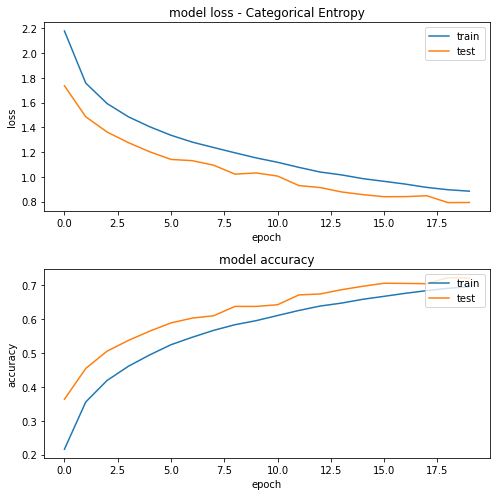

In [ ]:
plt.figure(figsize = (7,7))
plt.subplot(2,1,1)
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.title('model loss - Categorical Entropy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.subplot(2,1,2)
plt.plot(history_deep.history['categorical_accuracy'])
plt.plot(history_deep.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()